<a href="https://colab.research.google.com/github/mmm8sul/Course_work/blob/main/%D0%9A%D1%83%D1%80%D1%81%D0%BE%D0%B2%D0%B0%D1%8F_%D0%B2%D1%8B%D0%B2%D0%BE%D0%B4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.optim as optim
import torchvision.models as models

In [ ]:
!wget https://github.com/observethesun/sunspot_groups/raw/main/dataset/sunspot_dataset.zip
!unzip sunspot_dataset.zip

In [3]:
with zipfile.ZipFile('sunspot_dataset.zip', 'r') as my_zip:

    for file_name in my_zip.namelist():
        # extract files
        my_zip.extract(file_name, 'sunspot_dataset_files')

In [5]:
!git clone https://github.com/observethesun/helio.git
%cd /content/helio

fatal: destination path 'helio' already exists and is not an empty directory.
/content/helio


In [ ]:
!pip install -r requirements.txt

In [7]:
from helio import FilesIndex, HelioBatch, BatchSampler
from helio import VAE

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [8]:
net = VAE(in_channels=1,
    filters_enc=[16, 24, 32, 64],
    filters_dec=[48, 32, 24, 16],
    z_dim=16,
    output=dict(layout='c', filters=1),
    norm=True,
    variational=True).to(device)
vgg = models.vgg11(pretrained=True)
dis = vgg.features.to(device)
vgg_mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device)
vgg_std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device)

index = FilesIndex(path='/content/sunspot_dataset/*.npz', name='img').sort_index()
index

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:14<00:00, 36.9MB/s]


,img
FilesIndex,
201007230452_63,/content/sunspot_dataset/201007230452_63.npz
201007240414_63,/content/sunspot_dataset/201007240414_63.npz
201007250447_63,/content/sunspot_dataset/201007250447_63.npz
201007250447_64,/content/sunspot_dataset/201007250447_64.npz
201007260349_63,/content/sunspot_dataset/201007260349_63.npz
...,...
202008120532_31,/content/sunspot_dataset/202008120532_31.npz
202008120532_33,/content/sunspot_dataset/202008120532_33.npz
202008180351_34,/content/sunspot_dataset/202008180351_34.npz


In [9]:
def transform_channels(arr):
    out = (arr[..., 0] | arr[..., 2]).astype(np.float32)
    out[arr[..., 1]] = 2
    return np.expand_dims(out, 0) / 2 #normalize to [0, 1]

In [10]:
ind_for_del = [13, 8158, 5670, 5863, 2064, 2068, 444, 10, 7495, 4237, 4598, 6705, 2724, 11, 831, 4737,\
               4230, 3593, 4266, 909, 370, 4712, 826, 3583, 10, 2715, 7475, 4226,\
               823, 2709, 7458, 4216, 3576, 4569, 6669, 4704, 4209, 821, 2704, 7439, 4554, 3569, 6651, 4199, 4688,\
               365, 893, 4217, 4640, 6898, 894, 1108,\
               6873, 6666, 5448, 1181, 6609, 4160, 1634, 1136, 2129, 4190, 2379, 2049, 2452, 359, 726, 5821, 6641,\
               2138, 4230, 4220, 2159, 5335, 1095, 2920, 6946, 7147, 6630, 5297, 6689, 2138, 1277, 904
               ]

In [11]:
num_index=list(range(0,index.shape[0]))
num_index[-1]
index['indx']=num_index
index.head()

,img,indx
FilesIndex,,
201007230452_63,/content/sunspot_dataset/201007230452_63.npz,0
201007240414_63,/content/sunspot_dataset/201007240414_63.npz,1
201007250447_63,/content/sunspot_dataset/201007250447_63.npz,2
201007250447_64,/content/sunspot_dataset/201007250447_64.npz,3
201007260349_63,/content/sunspot_dataset/201007260349_63.npz,4


In [12]:
index.drop(index[index['indx'].isin(ind_for_del)].index, inplace=True)

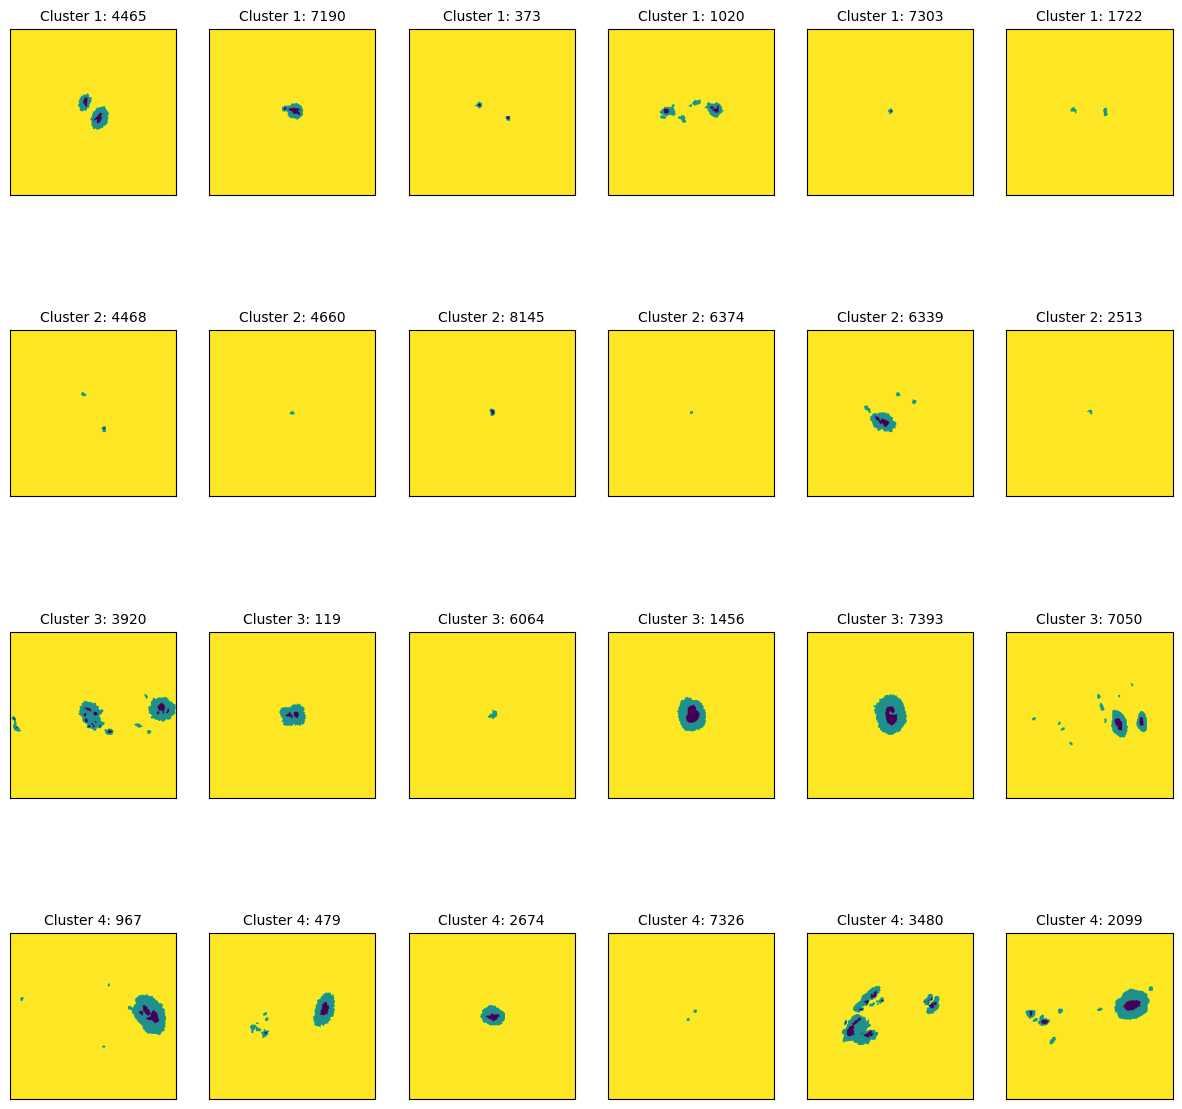

In [20]:
yellow_clust=[4465, 7190, 373, 1020, 7303, 1722]
green_clust=[4468, 4660, 8145, 6374, 6339, 2513]
blue_clust=[3920, 119, 6064, 1456, 7393, 7050]
purple_clust=[967, 479, 2674, 7326, 3480, 2099, 5304]

net = net.eval()

fig, ax = plt.subplots(4, 6, figsize=(15, 15))
fig.patch.set_facecolor('xkcd:white')

for i, color_clust in enumerate([yellow_clust, green_clust, blue_clust, purple_clust]):
    with torch.no_grad():
        batch = (HelioBatch(index.iloc[color_clust])
                 .load('img', sparse=True)
                 .apply(lambda x: x.toarray().reshape(256, 256, 3), src='img')
                 .apply(transform_channels, src='img'))
        x = torch.tensor(np.stack(batch.img)).to(device)

    for j in range(6):
        ax[i][j].imshow(1-x[j,0].detach().cpu().numpy(),vmin=0, vmax=1)
        ax[i][j].set_title('Cluster {}: {}'.format(i+1, color_clust[j]), fontsize=10)
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])

plt.show()

In [ ]:
index.iloc[1] # должно быть 201007240414_63	/content/sunspot_dataset/201007240414_63.npz